##### Load the nb_black formatter
pip install nb_black or conda install nb_black -- if not installed already

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

#### Load the required libraries

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow import keras

# Importing specific modules from libraries
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Importing User-defined functions from utilis
from main_utilis import read_data, data_from_to_numpy, std_normalise_data
from utils import augment_data, standard_model

# from utils import augment_data, standard_model
from equi_nn_utilis import (
    EquivariantHiddenLayer,
    EquivariantOutputLayer,
    eq_build_model,
)

# Setting numpy print options to display floating point numbers up to 3 decimal points
np.set_printoptions(precision=3, suppress=True)

<IPython.core.display.Javascript object>

### 1. Load the datasets

leakage dataset train [m].csv 

leakage dataset validation 1000.csv

and store the data as NumPy-Arrays
X train, Y train
X validation, Y validation.

#### Loading the data from CSV files

In [3]:
df_100, df_1000, df_val = read_data()

<IPython.core.display.Javascript object>

#### Load the features and label from dataframe and convert it to numpy array

In [4]:
X_train_100, y_train_100, X_train_1000, y_train_1000, X_val, y_val = data_from_to_numpy(
    df_100, df_1000, df_val
)

<IPython.core.display.Javascript object>

####  Standardize and normalize the data
For that purpose, you have training data (xi, yi)
mi=1 available. Unfortunately,
the fourth sensor MFC4 had a slight malfunction at the time when the training data were produced. As a consequence, the values x4 are on average
higher than their counterparts x1, x2 and x3. Be aware that the same effect
is not present in the validation and test data.

In [5]:
X_train_100_norm, X_train_1000_norm, X_val_norm = std_normalise_data(
    X_train_100, X_train_1000, X_val
)

<IPython.core.display.Javascript object>

### Train a standard fully connected neural network without hypertuning

In [6]:
# Augment the training data with the augment_data function for the training
x_train_augmented, y_train_augmented = augment_data(X_train_100_norm, y_train_100)
x_train_augmented_1000, y_train_augmented_1000 = augment_data(
    X_train_1000_norm, y_train_1000
)


<IPython.core.display.Javascript object>

In [7]:
# Convert the augmented data and labels to numpy arrays
X_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)
X_train_augmented_1000 = np.array(x_train_augmented_1000)
y_train_augmented_1000 = np.array(y_train_augmented_1000)

<IPython.core.display.Javascript object>

In [8]:
X_train_augmented[0]

array([0.425, 0.177, 0.153, 0.245])

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Data')

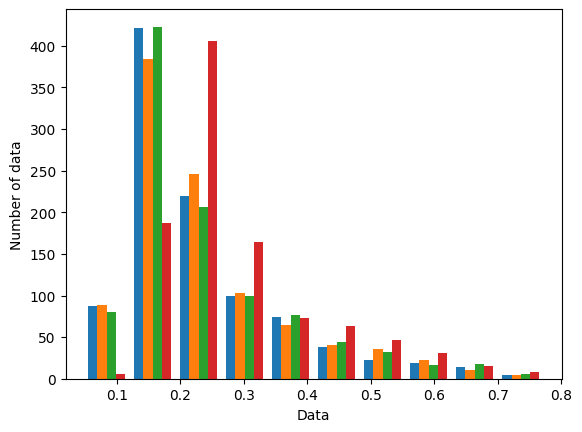

<IPython.core.display.Javascript object>

In [9]:
import seaborn as sns

# import matplotlib as plt
import matplotlib.pyplot as plt

%matplotlib inline


plt.hist(X_train_1000)
plt.ylabel("Number of data")
plt.xlabel("Data")

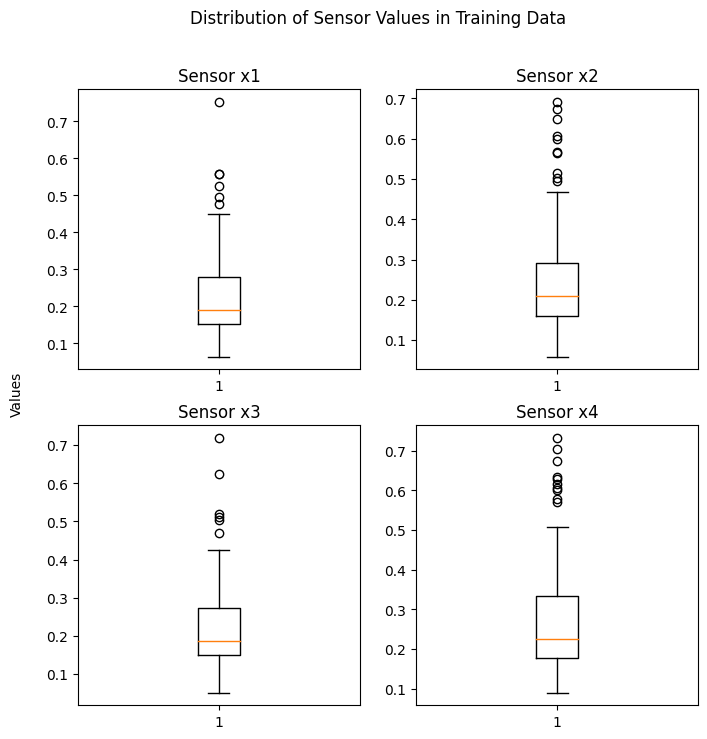

<IPython.core.display.Javascript object>

In [10]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Create box plots for each sensor
axs[0, 0].boxplot(X_train_100[:, 0])
axs[0, 0].set_title("Sensor x1")
axs[0, 1].boxplot(X_train_100[:, 1])
axs[0, 1].set_title("Sensor x2")
axs[1, 0].boxplot(X_train_100[:, 2])
axs[1, 0].set_title("Sensor x3")
axs[1, 1].boxplot(X_train_100[:, 3])
axs[1, 1].set_title("Sensor x4")

# Set y-axis label
fig.text(0.04, 0.5, "Values", va="center", rotation="vertical")

# Set title of the figure
fig.suptitle("Distribution of Sensor Values in Training Data")

# Show the plot
plt.show()

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Check for missing values
print("Number of missing values:\n", df_100.isnull().sum())


Number of missing values:
 y1      0
y2      0
mfc1    0
mfc2    0
mfc3    0
mfc4    0
dtype: int64


<IPython.core.display.Javascript object>

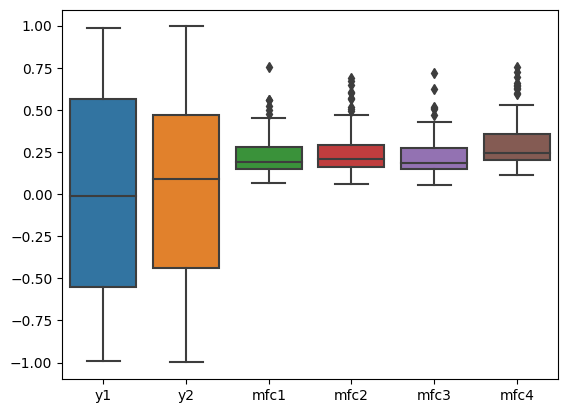

<IPython.core.display.Javascript object>

In [12]:
# Check for outliers
sns.boxplot(data=df_100[["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"]])
plt.show()


In [13]:
# Compute summary statistics
print(df_100.describe())


               y1          y2        mfc1        mfc2        mfc3        mfc4
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.007346    0.018768    0.229341    0.250908    0.223728    0.296022
std      0.623274    0.554963    0.123235    0.143254    0.116144    0.149442
min     -0.989400   -0.999599    0.064338    0.059517    0.051224    0.112402
25%     -0.551203   -0.440940    0.151041    0.159270    0.150773    0.200396
50%     -0.011000    0.089537    0.190749    0.210801    0.186552    0.246519
75%      0.567041    0.469571    0.279536    0.292609    0.272536    0.356549
max      0.988056    0.994551    0.752221    0.691295    0.718748    0.754062


<IPython.core.display.Javascript object>

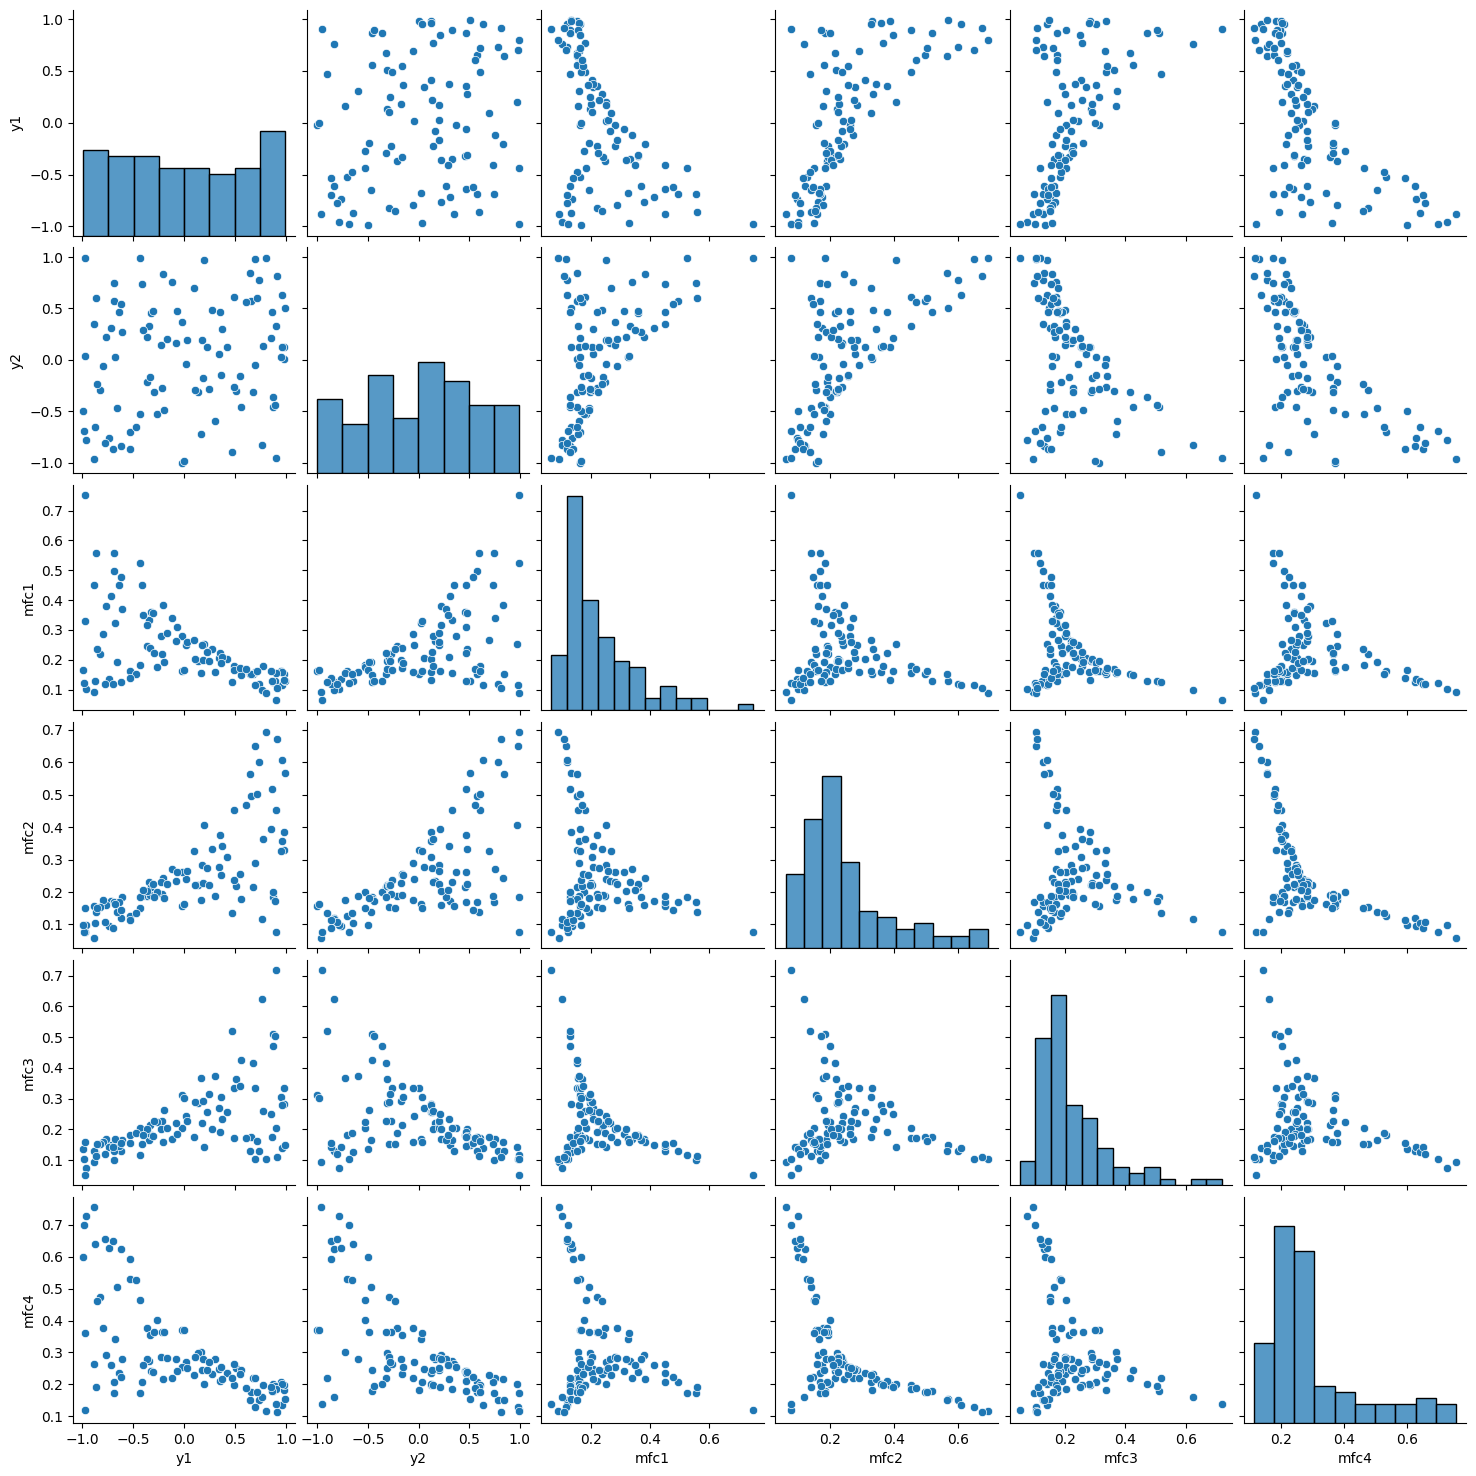

<IPython.core.display.Javascript object>

In [14]:

# Create scatterplot matrix
sns.pairplot(data=df_100, vars=["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"])
plt.show()


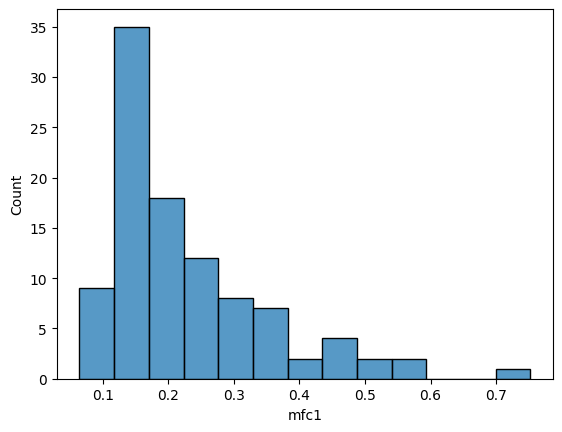

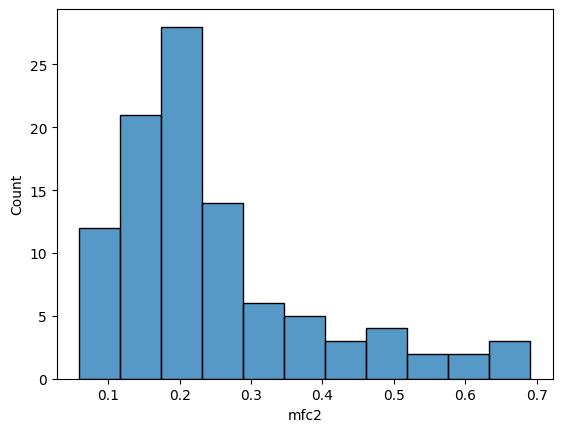

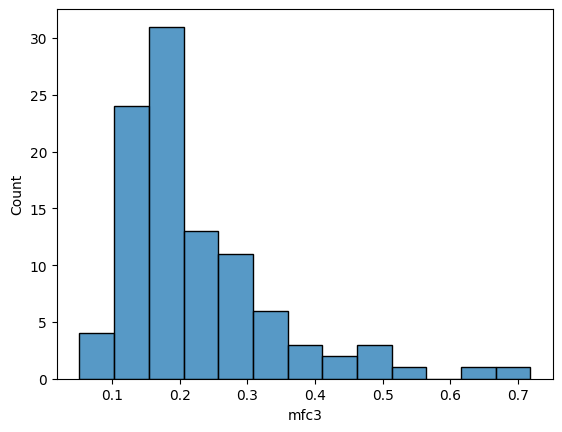

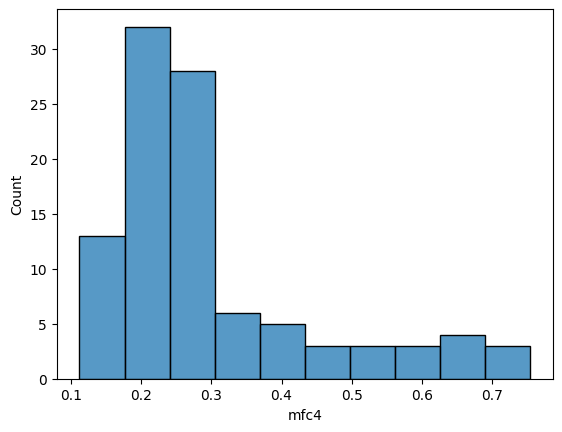

<IPython.core.display.Javascript object>

In [15]:
# Visualize the distribution of each feature
sns.histplot(data=df_100, x="mfc1")
plt.show()
sns.histplot(data=df_100, x="mfc2")
plt.show()
sns.histplot(data=df_100, x="mfc3")
plt.show()
sns.histplot(data=df_100, x="mfc4")
plt.show()


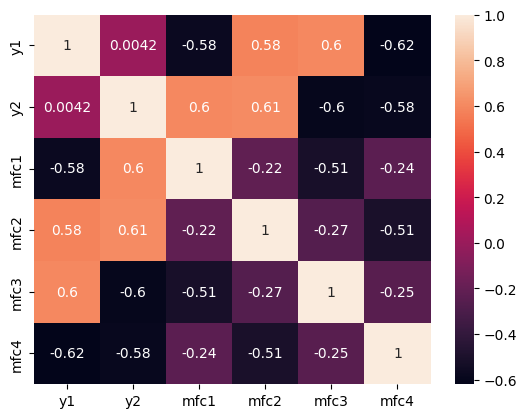

<IPython.core.display.Javascript object>

In [16]:
# Check for multicollinearity
corr_matrix = df_1000.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


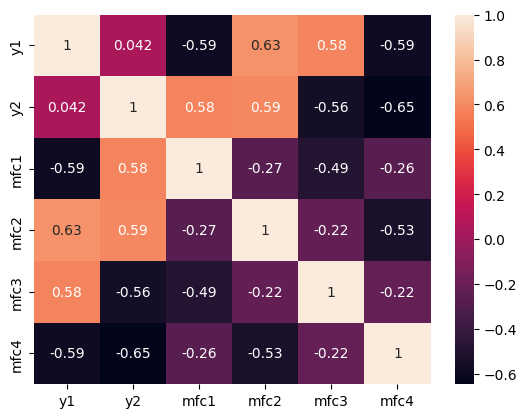

<IPython.core.display.Javascript object>

In [17]:
# Check for multicollinearity
corr_matrix = df_val.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [18]:
train_df = pd.concat([df_100, df_1000], axis=0)


<IPython.core.display.Javascript object>

In [19]:
print("Shape of dataframe:", train_df.shape)


Shape of dataframe: (1100, 6)


<IPython.core.display.Javascript object>

In [20]:
print(train_df.dtypes)


y1      float64
y2      float64
mfc1    float64
mfc2    float64
mfc3    float64
mfc4    float64
dtype: object


<IPython.core.display.Javascript object>

In [21]:
print("Number of missing values:\n", train_df.isnull().sum())


Number of missing values:
 y1      0
y2      0
mfc1    0
mfc2    0
mfc3    0
mfc4    0
dtype: int64


<IPython.core.display.Javascript object>

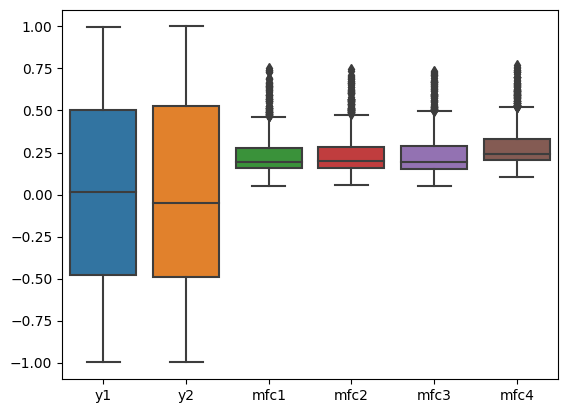

<IPython.core.display.Javascript object>

In [22]:
sns.boxplot(data=train_df[["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"]])
plt.show()


In [23]:
print(train_df.describe())


                y1           y2         mfc1         mfc2         mfc3  \
count  1100.000000  1100.000000  1100.000000  1100.000000  1100.000000   
mean      0.011325     0.001441     0.234882     0.239766     0.239015   
std       0.577087     0.584406     0.125509     0.128988     0.129330   
min      -0.994880    -0.999599     0.049455     0.059517     0.047981   
25%      -0.476337    -0.493717     0.155165     0.155429     0.154773   
50%       0.017736    -0.052133     0.191525     0.197689     0.191575   
75%       0.502188     0.527494     0.277565     0.284214     0.291637   
max       0.999341     0.999975     0.752221     0.746359     0.734298   

              mfc4  
count  1100.000000  
mean      0.286338  
std       0.129901  
min       0.104274  
25%       0.202950  
50%       0.240303  
75%       0.329394  
max       0.772133  


<IPython.core.display.Javascript object>

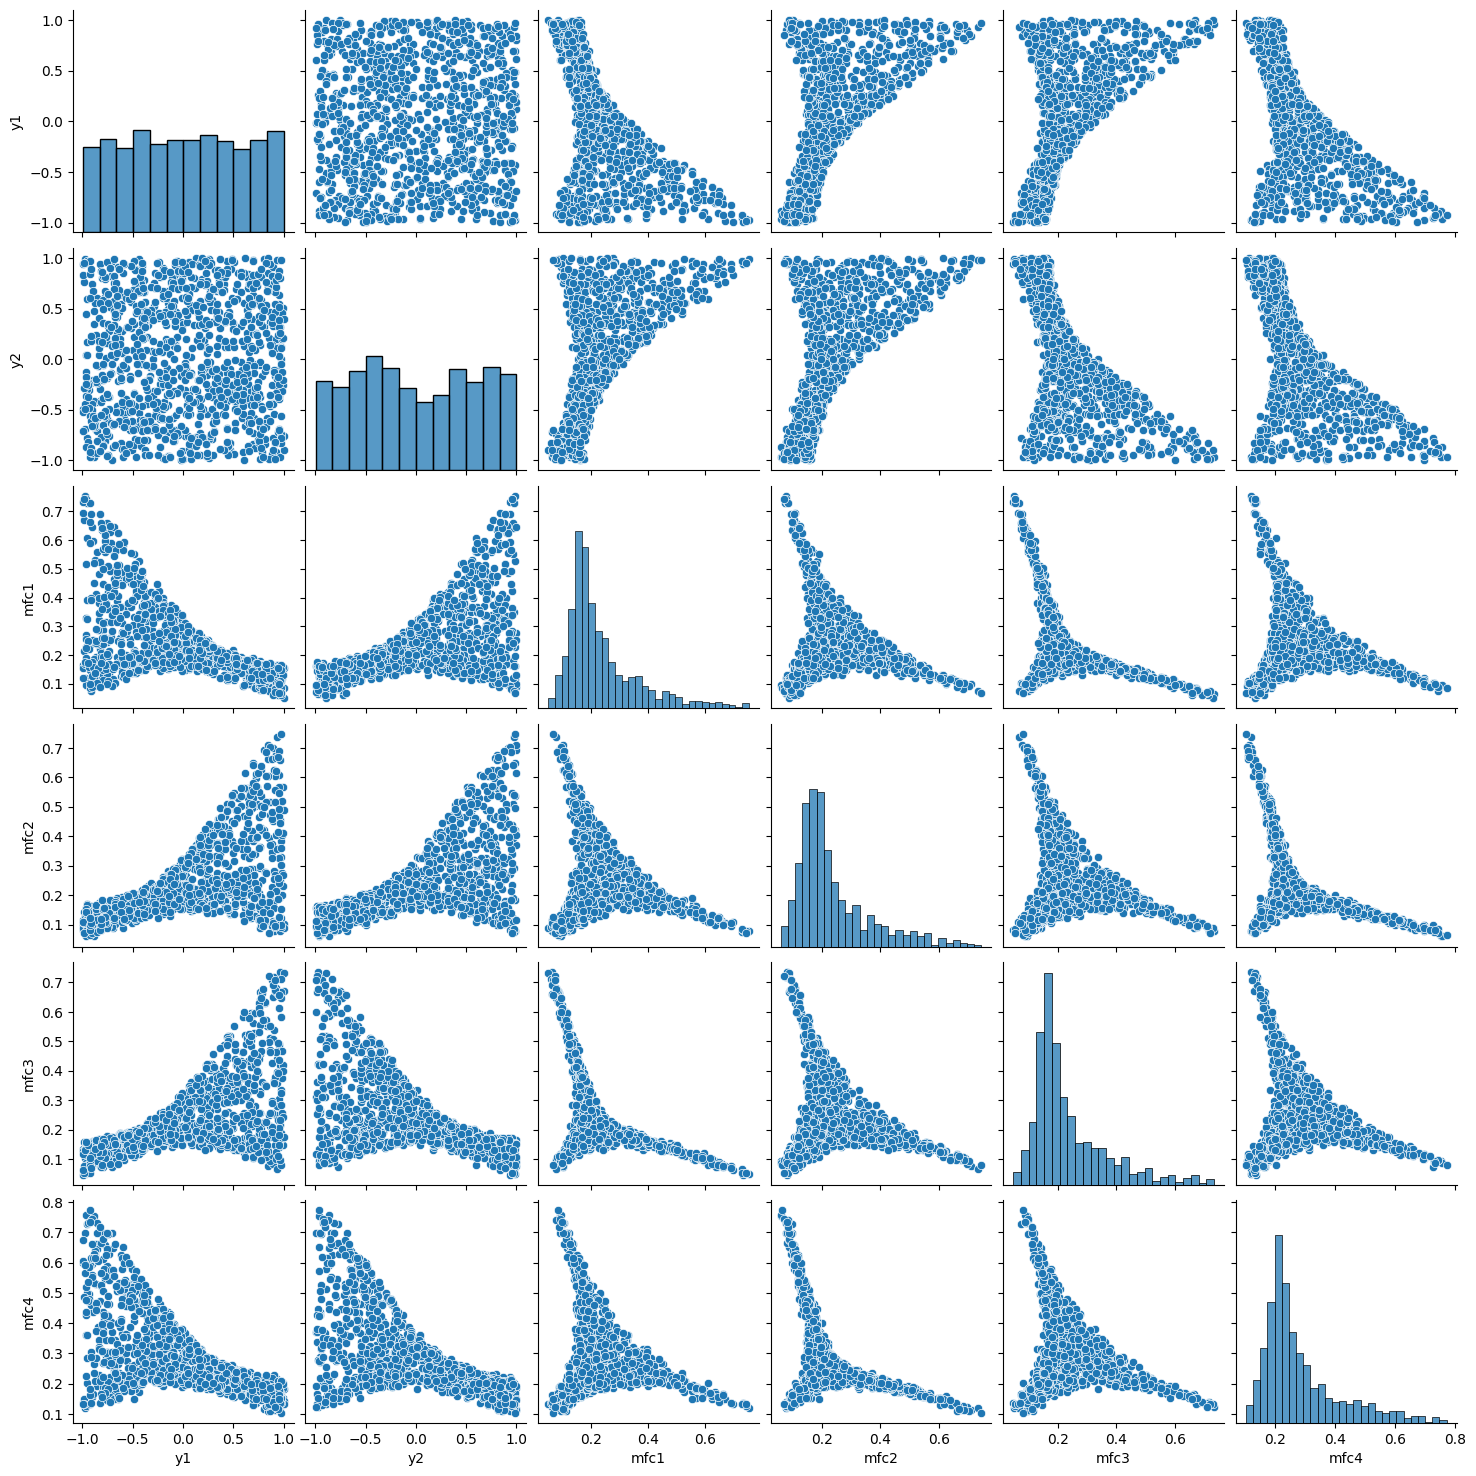

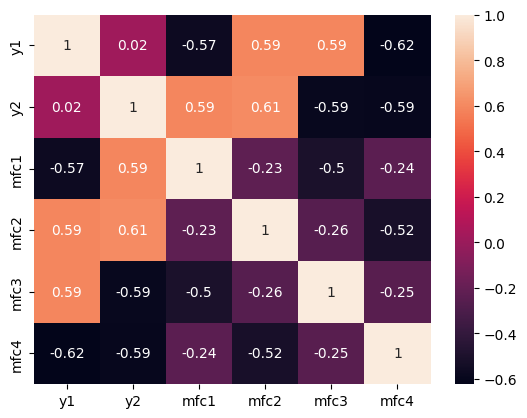

<IPython.core.display.Javascript object>

In [24]:
sns.pairplot(data=train_df, vars=["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"])
plt.show()

corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


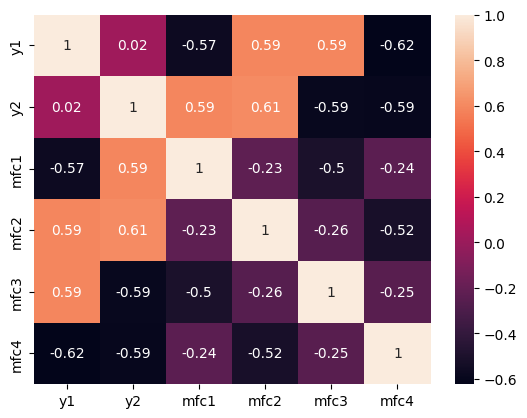

<IPython.core.display.Javascript object>

In [25]:
corr_matrix = train_df[["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


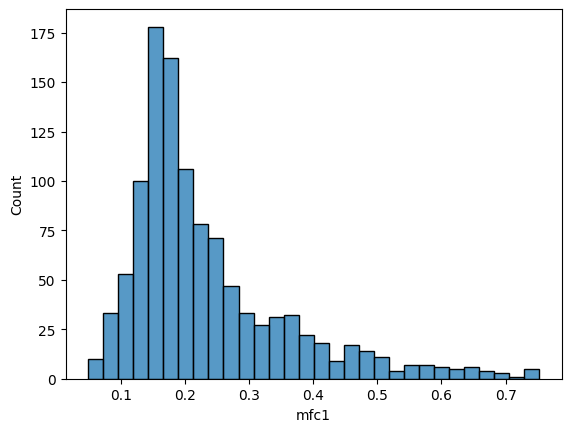

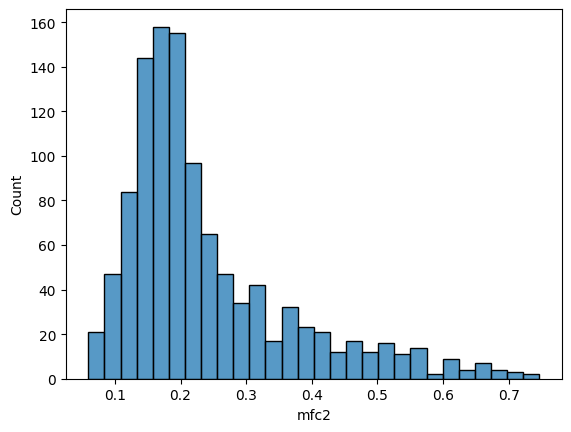

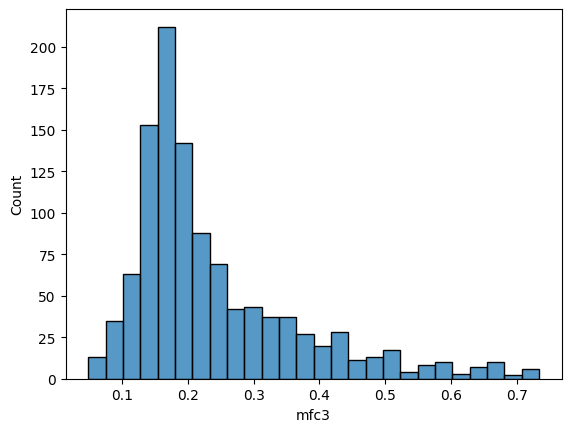

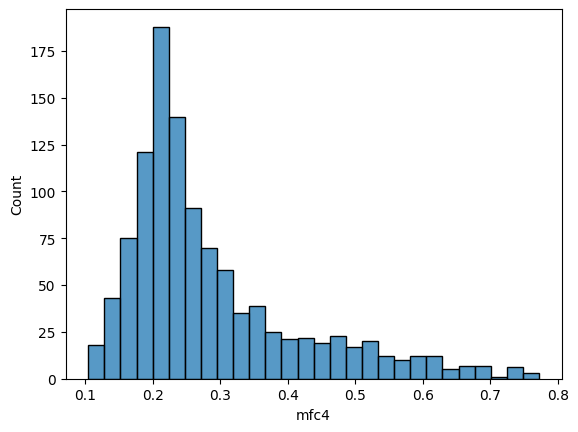

<IPython.core.display.Javascript object>

In [26]:
sns.histplot(data=train_df, x="mfc1")
plt.show()
sns.histplot(data=train_df, x="mfc2")
plt.show()
sns.histplot(data=train_df, x="mfc3")
plt.show()
sns.histplot(data=train_df, x="mfc4")
plt.show()


Shape of validation dataframe: (1000, 6)
y1      float64
y2      float64
mfc1    float64
mfc2    float64
mfc3    float64
mfc4    float64
dtype: object
Number of missing values:
 y1      0
y2      0
mfc1    0
mfc2    0
mfc3    0
mfc4    0
dtype: int64


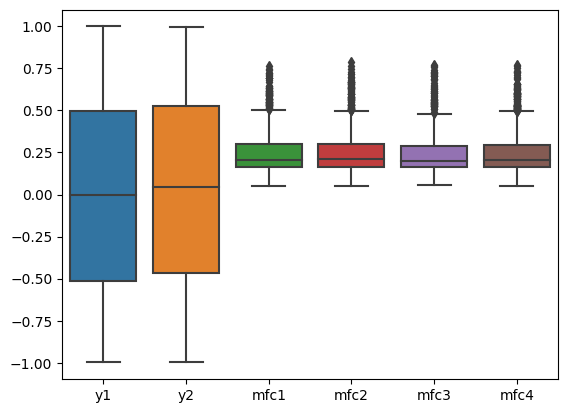

<IPython.core.display.Javascript object>

In [27]:
# Check the shape of the validation data frame
print("Shape of validation dataframe:", df_val.shape)

# Check the data types of each column
print(df_val.dtypes)

# Check for missing values
print("Number of missing values:\n", df_val.isnull().sum())

# Check for outliers
sns.boxplot(data=df_val[["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"]])
plt.show()





                y1           y2         mfc1         mfc2         mfc3  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.000449     0.021552     0.251771     0.254362     0.242496   
std       0.576881     0.574105     0.134727     0.137332     0.126907   
min      -0.998303    -0.997706     0.053497     0.048913     0.056594   
25%      -0.512533    -0.467583     0.162346     0.163444     0.160775   
50%      -0.003398     0.045050     0.202735     0.208306     0.200071   
75%       0.497650     0.528958     0.299356     0.298409     0.287794   
max       0.998827     0.998219     0.765563     0.787330     0.770750   

              mfc4  
count  1000.000000  
mean      0.251371  
std       0.136694  
min       0.049417  
25%       0.162701  
50%       0.205535  
75%       0.295472  
max       0.769762  


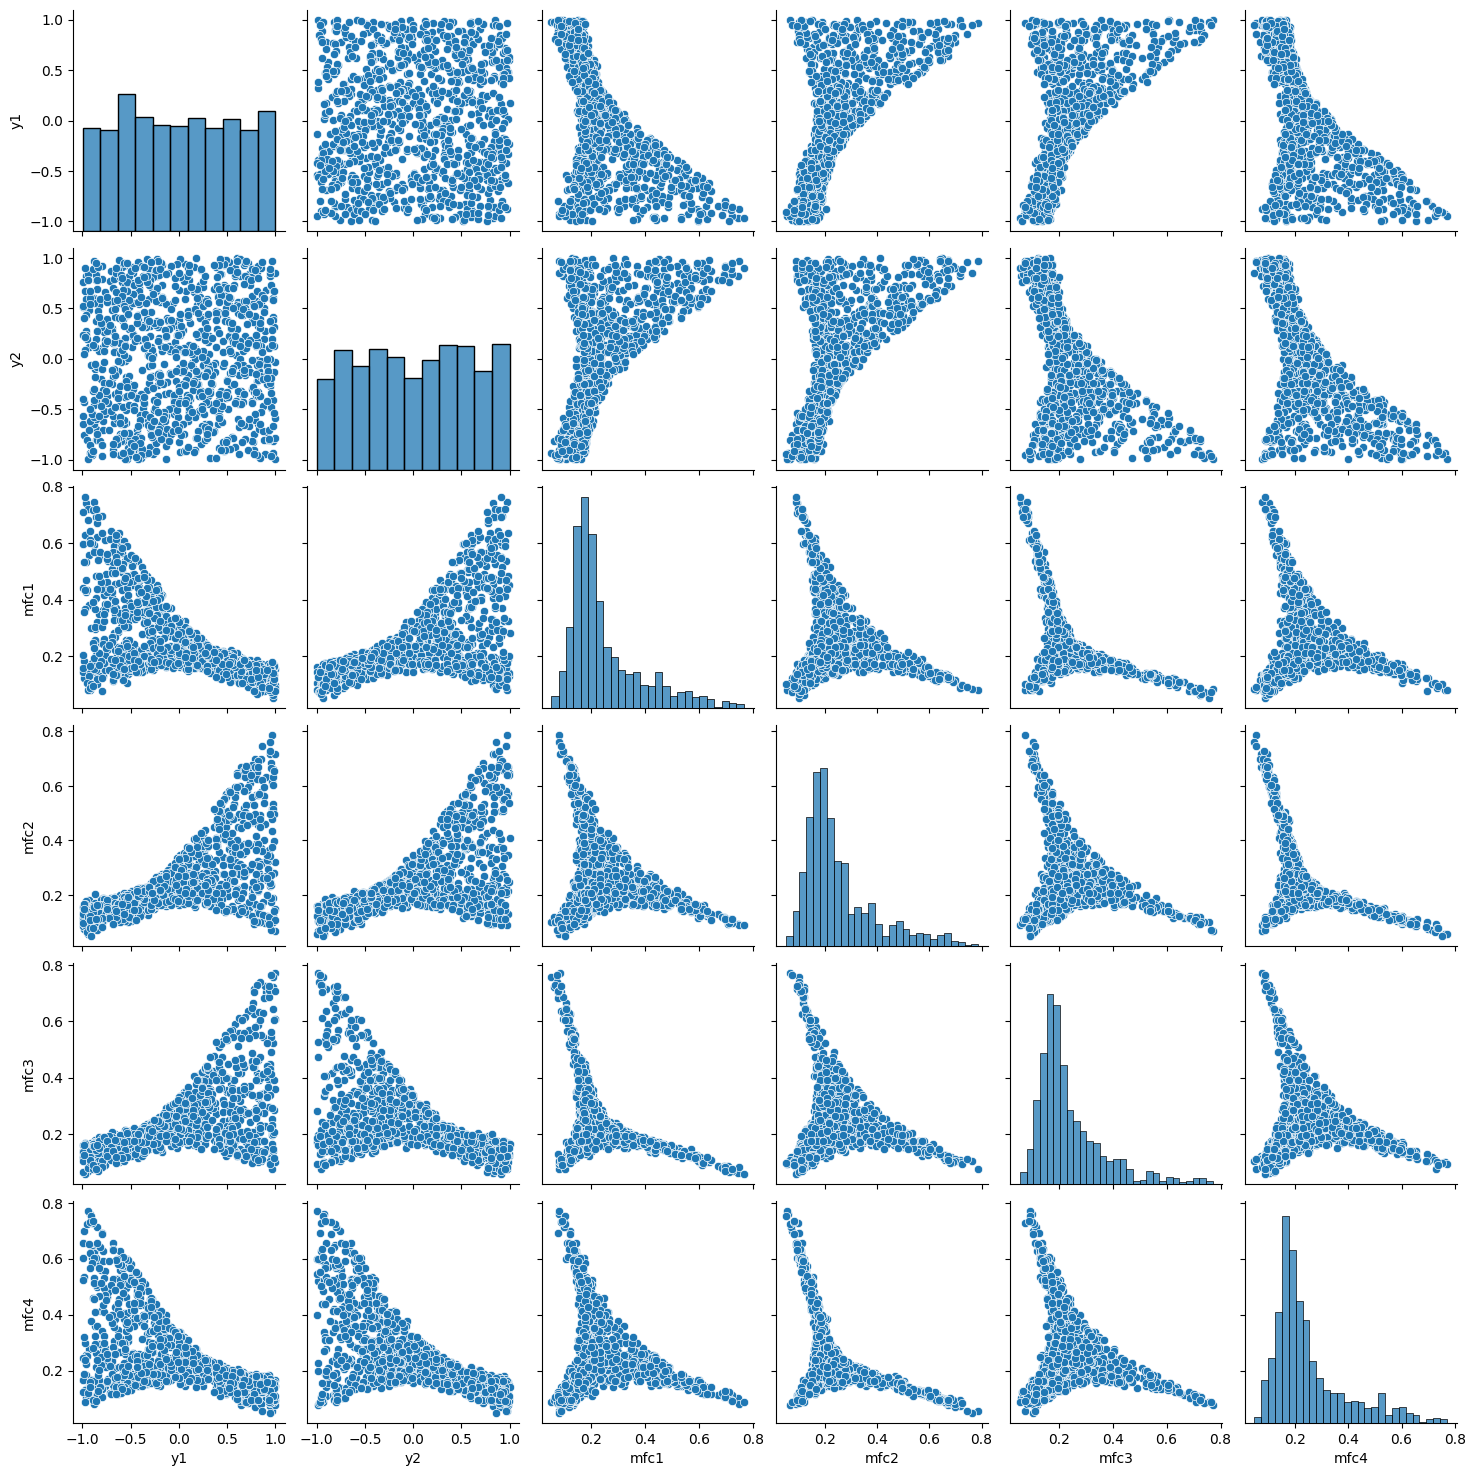

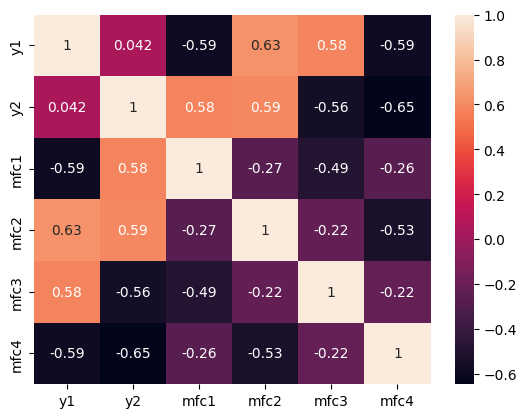

<IPython.core.display.Javascript object>

In [28]:
# Compute summary statistics
print(df_val.describe())

# Create scatterplot matrix
sns.pairplot(data=df_val, vars=["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"])
plt.show()

# Check for multicollinearity
corr_matrix = df_val[["y1", "y2", "mfc1", "mfc2", "mfc3", "mfc4"]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

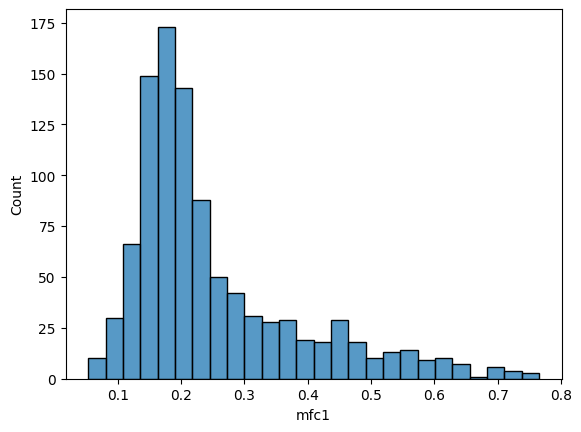

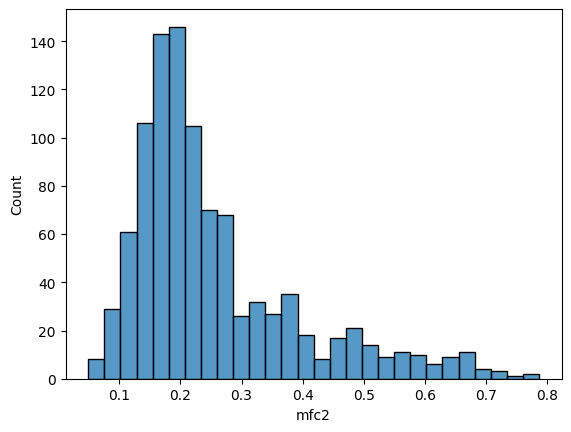

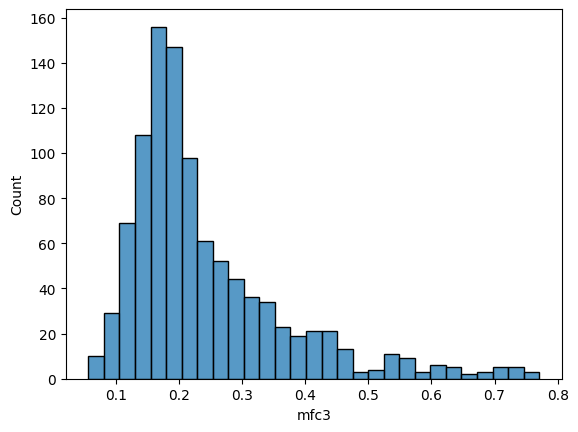

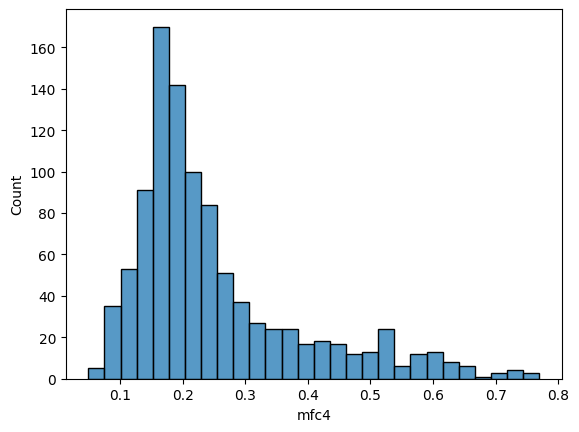

<IPython.core.display.Javascript object>

In [29]:
sns.histplot(data=df_val, x="mfc1")
plt.show()
sns.histplot(data=df_val, x="mfc2")
plt.show()
sns.histplot(data=df_val, x="mfc3")
plt.show()
sns.histplot(data=df_val, x="mfc4")
plt.show()


In [30]:
print(X_train_augmented[0:8])
y_train_augmented[0:9]

[[0.425 0.177 0.153 0.245]
 [0.245 0.425 0.177 0.153]
 [0.153 0.245 0.425 0.177]
 [0.177 0.153 0.245 0.425]
 [0.177 0.425 0.245 0.153]
 [0.425 0.245 0.153 0.177]
 [0.245 0.153 0.177 0.425]
 [0.153 0.177 0.425 0.245]]


array([[-0.716,  0.313],
       [ 0.313,  0.716],
       [ 0.716, -0.313],
       [-0.313, -0.716],
       [-0.716, -0.313],
       [ 0.313, -0.716],
       [ 0.716,  0.313],
       [-0.313,  0.716],
       [-0.884, -0.963]])

<IPython.core.display.Javascript object>

In [31]:
X_train_100_norm[0]

array([0.425, 0.177, 0.153, 0.245])

<IPython.core.display.Javascript object>

In [32]:
def display_item_1(X, y):
    for i in range(X.shape[0]):
        # plot x points, x - intensity of borders
        plt.scatter([0.9, -0.9, -0.9, 0.9], [0.9, 0.9, -0.9, -0.9], s=X[i] * 600)
        plt.scatter(y[i][1], y[i][0], s=200, color="red")
        plt.axis("square")
        plt.show()


<IPython.core.display.Javascript object>

In [33]:
def display_item_2(X, y):
    n_items = X.shape[0]
    n_rows = (n_items + 3) // 4
    fig, axs = plt.subplots(n_rows, 4, figsize=(16, 4*n_rows))
    
    for i in range(n_items):
        row_idx = i // 4
        col_idx = i % 4
        
        axs[row_idx, col_idx].scatter([0.9, -0.9, -0.9, 0.9], [0.9, 0.9, -0.9, -0.9], s=X[i] * 600)
        axs[row_idx, col_idx].scatter(y[i][1], y[i][0], s=200, color="red")
        axs[row_idx, col_idx].set_xlim([-1.2, 1.2])
        axs[row_idx, col_idx].set_ylim([-1.2, 1.2])
        axs[row_idx, col_idx].set_aspect('equal', adjustable='box')
    
    plt.show()


<IPython.core.display.Javascript object>

In [34]:
def display_item_3(X, y):
    n = X.shape[0]
    num_rows = n // 4 + (n % 4 > 0)  # number of rows needed
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))
    for i in range(n):
        row, col = i // 4, i % 4
        ax = axes[row, col]
        ax.scatter([0.9, -0.9, -0.9, 0.9], [0.9, 0.9, -0.9, -0.9], s=X[i] * 600)
        ax.scatter(y[i][1], y[i][0], s=200, color="red")
        ax.axis("square")
    plt.show()


<IPython.core.display.Javascript object>

In [35]:
def display_item_4(X, y):
    n = X.shape[0]
    num_rows = n // 4 + (n % 4 > 0)  # number of rows needed
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))
    for i in range(n):
        row, col = i // 4, i % 4
        ax = axes[row, col]
        ax.scatter([1.0, -1.0, -1.0, 1.0], [1.0, 1.0, -1.0, -1.0], s=X[i] * 600)
        ax.scatter(y[i][1], y[i][0], s=200, color="red")
        ax.axis("square")
    plt.show()


<IPython.core.display.Javascript object>

In [36]:
x = np.array([0.415255516, 0.173617510, 0.149737795, 0.261389179])
y = np.array([-0.715718463, -0.312582757])

<IPython.core.display.Javascript object>

In [37]:
x.shape

(4,)

<IPython.core.display.Javascript object>

In [38]:
def display_item_5(x, y):
    # plot x points, x - intensity of borders
    plt.scatter([0.9, -0.9, -0.9, 0.9], [0.9, 0.9, -0.9, -0.9], s=x * 600)
    # plot y as coordinates
    plt.scatter(y[1], y[0], s=200, color="red")
    plt.axis("square")
    plt.show()

<IPython.core.display.Javascript object>

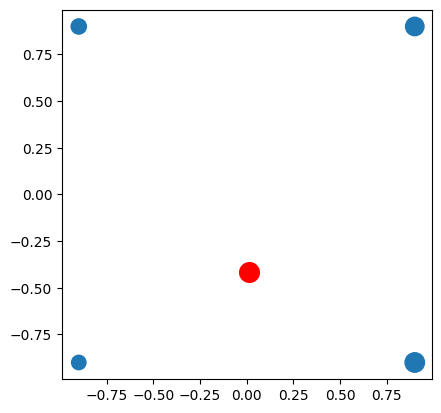

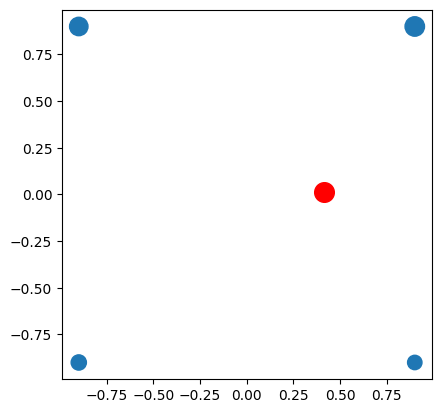

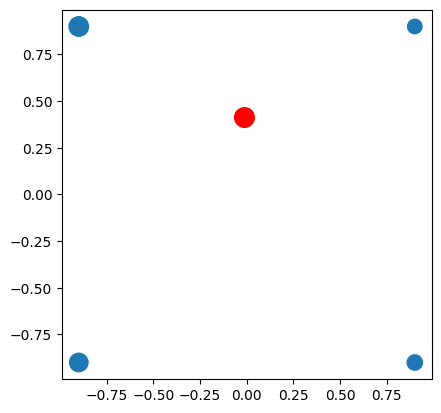

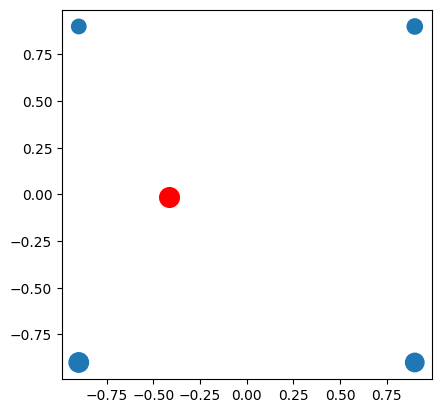

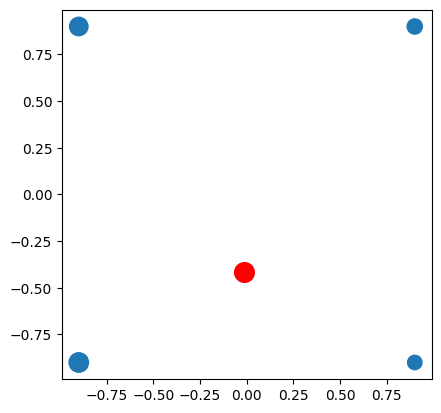

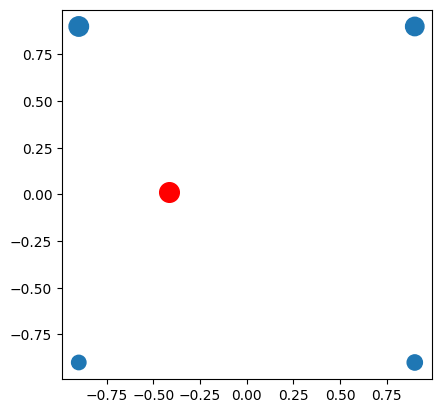

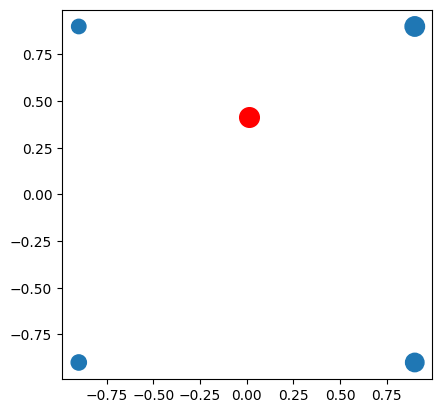

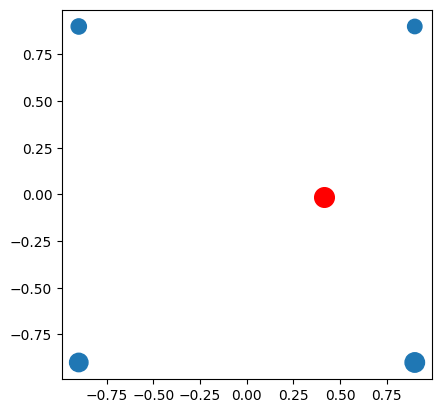

<IPython.core.display.Javascript object>

In [39]:
display_item_1(X_train_augmented_1000[0:8], y_train_augmented_1000[0:8])

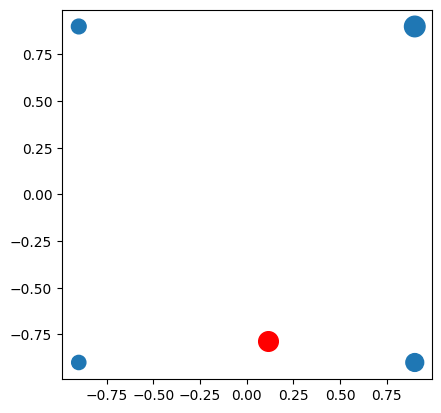

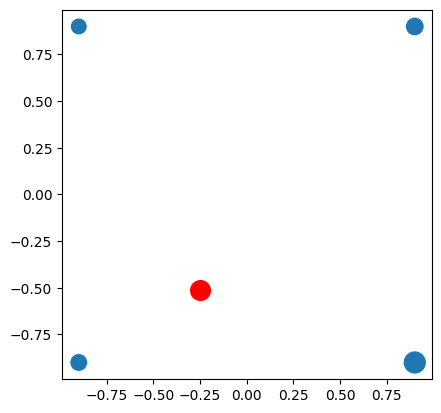

<IPython.core.display.Javascript object>

In [40]:
display_item_1(X_val_norm[0:2], y_val[0:2])

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_data(x_train, y_train, x_train_aug, y_train_aug):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], hue=y_train[:, 0], ax=axes[0, 0])
    sns.scatterplot(x=x_train_aug[:, 0], y=x_train_aug[:, 1], hue=y_train_aug[:, 0], ax=axes[0, 1])
    sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train[:, 1], ax=axes[1, 0])
    sns.scatterplot(x=x_train_aug[:, 2], y=x_train_aug[:, 3], hue=y_train_aug[:, 1], ax=axes[1, 1])

    axes[0, 0].set_title('Original X1 vs. X2')
    axes[0, 1].set_title('Augmented X1 vs. X2')
    axes[1, 0].set_title('Original X3 vs. X4')
    axes[1, 1].set_title('Augmented X3 vs. X4')
    
    plt.show()


<IPython.core.display.Javascript object>

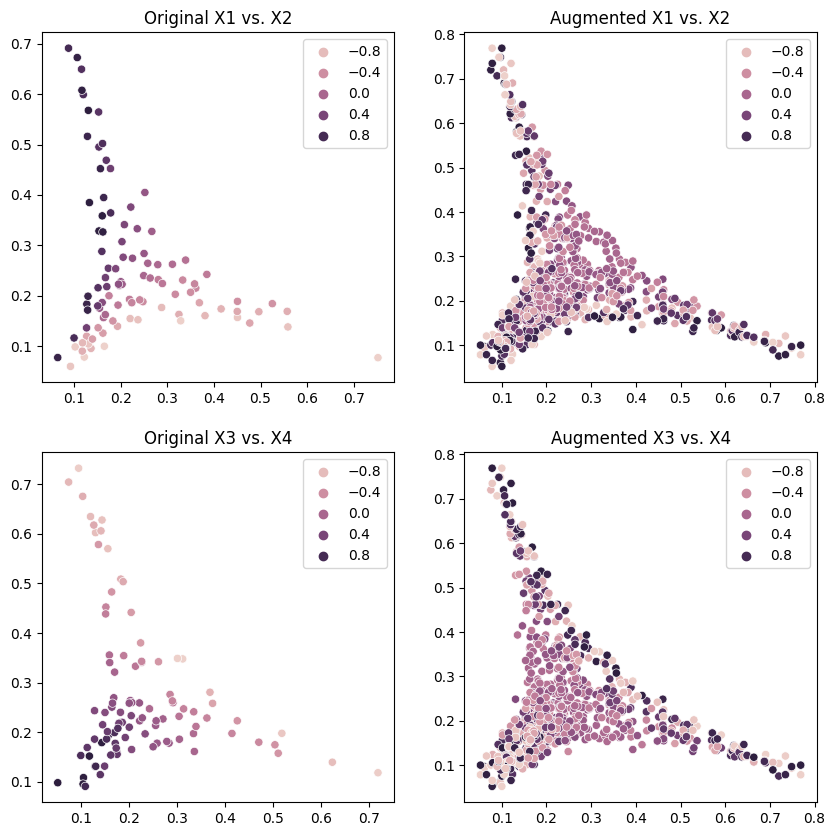

<IPython.core.display.Javascript object>

In [42]:
display_data(X_train_100, y_train_100, X_train_augmented, y_train_augmented)

In [43]:
import matplotlib.pyplot as plt


def display_item_all(X, y):
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flat):
        if i < 8:
            ax.scatter([1.0, -1.0, -1.0, 1.0], [1.0, 1.0, -1.0, -1.0], s=X[i] * 300)
            ax.scatter(y[i][1], y[i][0], s=100, color="red")
            ax.annotate(
                "({:.2f}, {:.2f})".format(y[i][1], y[i][0]),
                (y[i][1], y[i][0]),
                xytext=(10, 10),
                textcoords="offset points",
            )
            ax.axis("square")
            ax.set_title("X={0}\nY={1}".format(X[i], y[i]))
    plt.show()

<IPython.core.display.Javascript object>

In [73]:
import matplotlib.pyplot as plt

def display_item_all(X, y, filename=None):
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flat):
        if i < 8:
            ax.scatter([1.0, -1.0, -1.0, 1.0], [1.0, 1.0, -1.0, -1.0], s=X[i] * 300)
            ax.scatter(y[i][1], y[i][0], s=100, color="orange")
            ax.annotate(
                "({:.2f}, {:.2f})".format(y[i][1], y[i][0]),
                (y[i][1], y[i][0]),
                xytext=(10, 10),
                textcoords="offset points",
            )
            ax.axis("square")
            ax.set_title("X={0}\nY={1}".format(X[i], y[i]))
    if filename is not None:
        plt.savefig(filename,dpi=400)
    else:
        plt.show()


<IPython.core.display.Javascript object>

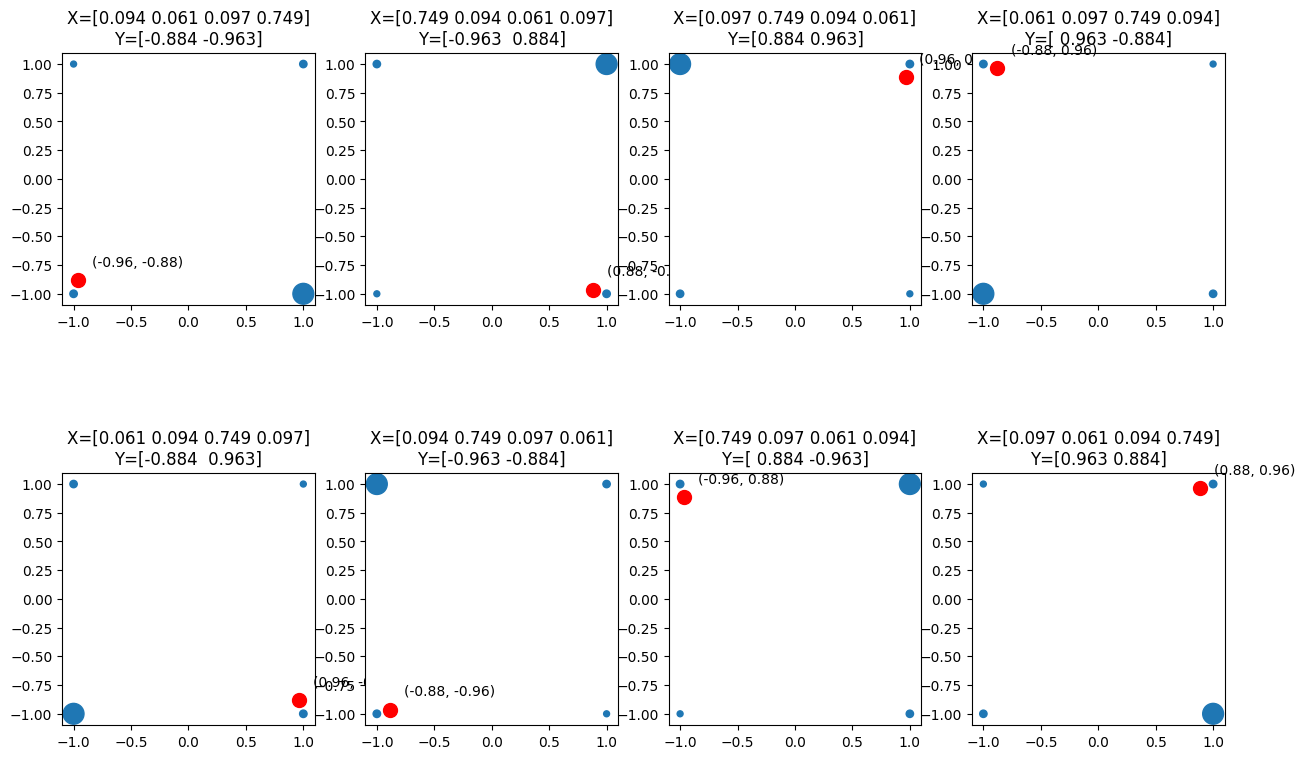

<IPython.core.display.Javascript object>

In [66]:
display_item_all(X_train_augmented[8:16], y_train_augmented[8:16], "augmented_data.png")

In [64]:
X_train_augmented[16:24]

array([[0.156, 0.336, 0.343, 0.165],
       [0.165, 0.156, 0.336, 0.343],
       [0.343, 0.165, 0.156, 0.336],
       [0.336, 0.343, 0.165, 0.156],
       [0.336, 0.156, 0.165, 0.343],
       [0.156, 0.165, 0.343, 0.336],
       [0.165, 0.343, 0.336, 0.156],
       [0.343, 0.336, 0.156, 0.165]])

<IPython.core.display.Javascript object>

In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def display_item_plotly(X, y):
    fig = make_subplots(rows=2, cols=4, subplot_titles=[f"X={X[i]}\nY={y[i]}" for i in range(8)])
    marker_size = [x*200 for x in X]
    for i in range(8):
        fig.add_trace(
            go.Scatter(x=[1.0, -1.0, -1.0, 1.0], y=[1.0, 1.0, -1.0, -1.0], 
                       mode='markers', marker_size=marker_size[i], marker=dict(color='blue')), 
            row=(i//4)+1, col=(i%4)+1
        )
        fig.add_trace(
            go.Scatter(x=[y[i][1]], y=[y[i][0]], 
                       mode='markers', marker_size=5, marker=dict(color='red')),
            row=(i//4)+1, col=(i%4)+1
        )
        fig.add_annotation(
            x=y[i][1], y=y[i][0], 
            text=f"({y[i][1]:.2f}, {y[i][0]:.2f})", 
            showarrow=False, font=dict(size=10), 
            xanchor='left', yanchor='bottom', 
            xshift=10, yshift=10,
        )
        fig.update_xaxes(range=[-1.2, 1.2], autorange=False, row=(i//4)+1, col=(i%4)+1)
        fig.update_yaxes(range=[-1.2, 1.2], autorange=False, row=(i//4)+1, col=(i%4)+1)
    fig.update_layout(width=1800, height=720, showlegend=False)
    fig.show()


<IPython.core.display.Javascript object>

In [46]:
display_item_plotly(X_train_augmented[0:8], y_train_augmented[0:8])

<IPython.core.display.Javascript object>

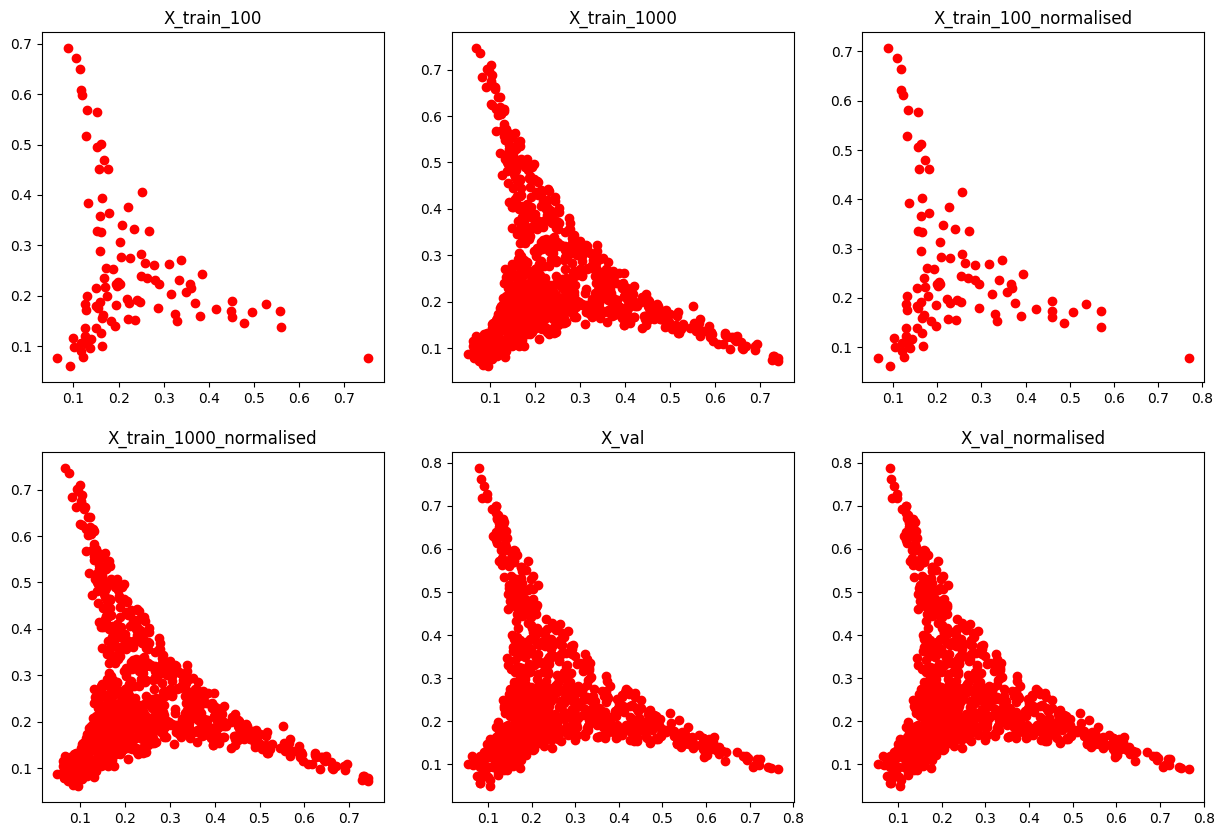

<IPython.core.display.Javascript object>

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].plot(X_train_100[:, 0], X_train_100[:, 1], 'ro')
axs[0, 0].set_title('X_train_100')

axs[0, 1].plot(X_train_1000[:, 0], X_train_1000[:, 1], 'ro')
axs[0, 1].set_title('X_train_1000')

axs[0, 2].plot(X_train_100_norm[:, 0], X_train_100_norm[:, 1], 'ro')
axs[0, 2].set_title('X_train_100_normalised')

axs[1, 0].plot(X_train_1000_norm[:, 0], X_train_1000_norm[:, 1], 'ro')
axs[1, 0].set_title('X_train_1000_normalised')

axs[1, 1].plot(X_val[:, 0], X_val[:, 1], 'ro')
axs[1, 1].set_title('X_val')

axs[1, 2].plot(X_val_norm[:, 0], X_val_norm[:, 1], 'ro')
axs[1, 2].set_title('X_val_normalised')

plt.show()


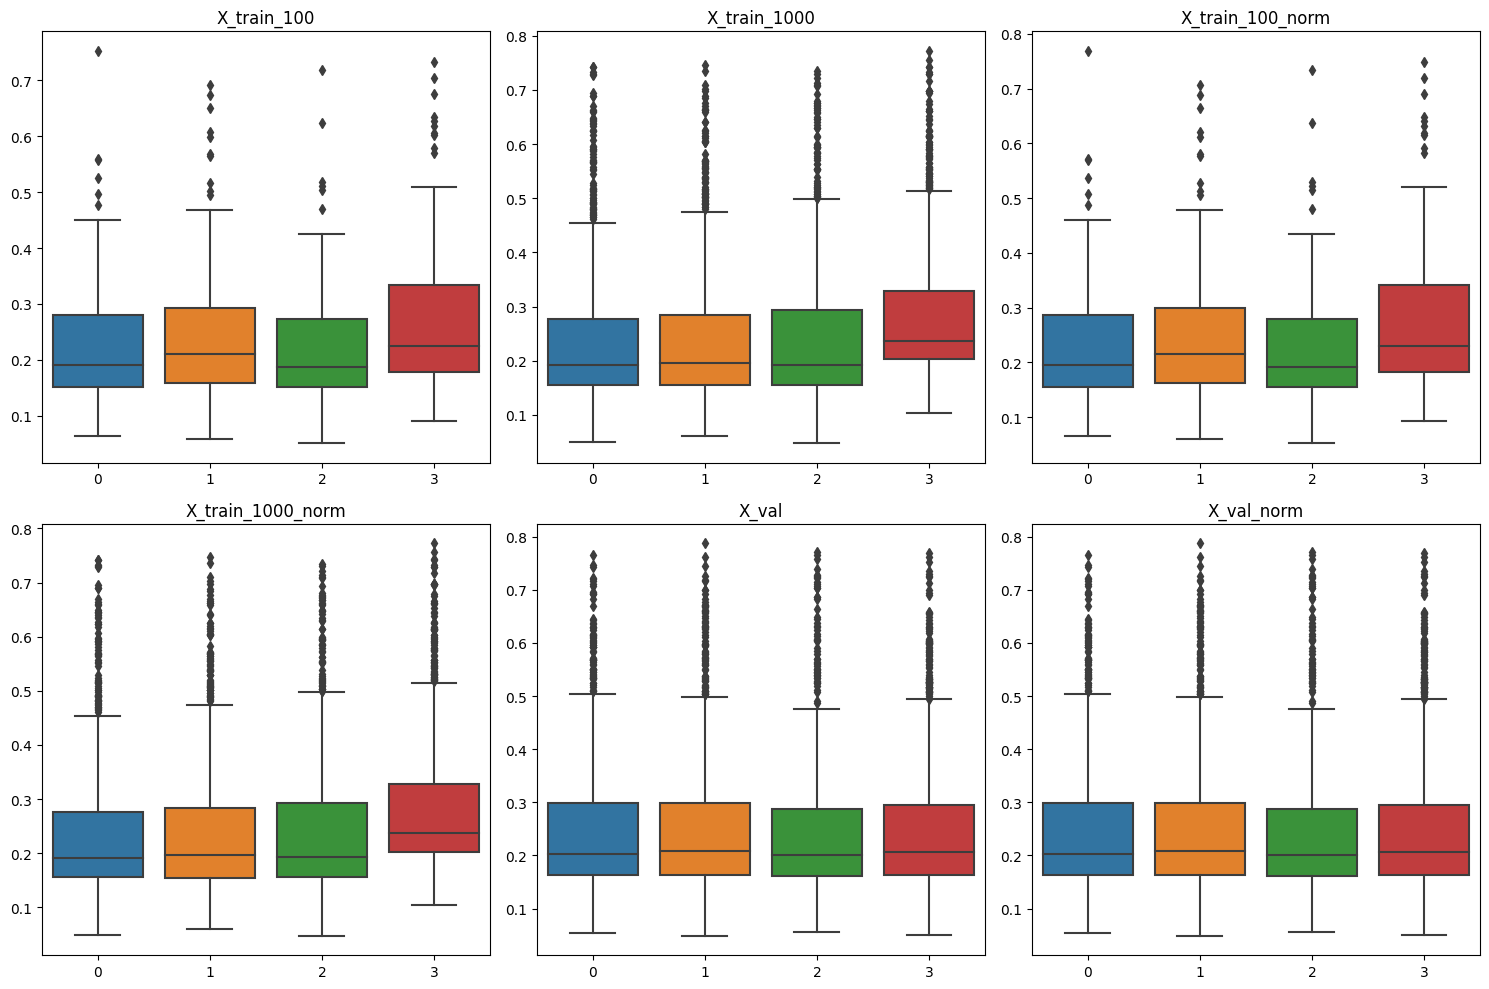

<IPython.core.display.Javascript object>

In [49]:
import seaborn as sns

# create a list of the arrays
arrays = [X_train_100, X_train_1000, X_train_100_norm, X_train_1000_norm, X_val, X_val_norm]

# create a list of the array names
names = ['X_train_100', 'X_train_1000', 'X_train_100_norm', 'X_train_1000_norm', 'X_val', 'X_val_norm']

# create a figure with 2x3 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# loop over the arrays and names
for i, (array, name) in enumerate(zip(arrays, names)):
    # get the subplot axes
    ax = axs[i // 3, i % 3]
    # create the box plot
    sns.boxplot(data=array, ax=ax)
    # set the title
    ax.set_title(name)

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()


In [67]:
def augment_data_h(x_train, y_train):
    # initialize empty lists for augmented data and labels
    x_train_aug = []
    y_train_aug = []

    for i in range(len(x_train)):
        x_train_aug.append(x_train[i])
        y_train_aug.append(y_train[i])

        # 90 degree clockwise rotation
        x_train_aug.append(
            (np.array([x_train[i][3], x_train[i][0], x_train[i][1], x_train[i][2]]))
        )
        y_train_aug.append(np.array([y_train[i][1], -y_train[i][0]]))

        # 180 degree clockwise rotation
        x_train_aug.append(
            (np.array([x_train[i][2], x_train[i][3], x_train[i][0], x_train[i][1]]))
        )
        y_train_aug.append((np.array([-y_train[i][0], -y_train[i][1]])))

        # 270 degree clockwise rotation
        x_train_aug.append(
            (np.array([x_train[i][1], x_train[i][2], x_train[i][3], x_train[i][0]]))
        )
        y_train_aug.append((np.array([-y_train[i][1], y_train[i][0]])))

        # vertical flip
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][0], x_train[i][1], x_train[i][2], x_train[i][3]])[
                    [2, 3, 0, 1]
                ]
            )
        )
        #         y_train_aug.append(np.flip(np.array([y_train[i][0], y_train[i][1]])))
        y_train_aug.append(np.flip(np.array([y_train[i][1], -y_train[i][0]])))

        # horizontal flip + 90 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][3], x_train[i][0], x_train[i][1], x_train[i][2]])
            )[[2, 3, 0, 1]]
        )
        #         y_train_aug.append(np.flip(np.array([y_train[i][1], -y_train[i][0]])))
        #         y_train_aug.append(np.flip(np.array([y_train[i][0], y_train[i][1]])))
        y_train_aug.append(np.flip(np.array([-y_train[i][0], -y_train[i][1]])))

        # horizontal flip + 180 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][2], x_train[i][3], x_train[i][0], x_train[i][1]])
            )[[2, 3, 0, 1]]
        )
        #         y_train_aug.append(np.flip(np.array([-y_train[i][0], -y_train[i][1]])))
        y_train_aug.append(np.flip(np.array([-y_train[i][1], y_train[i][0]])))

        # horizontal flip + 270 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][1], x_train[i][2], x_train[i][3], x_train[i][0]])
            )[[2, 3, 0, 1]]
        )
        #         y_train_aug.append(np.flip(np.array([-y_train[i][1], y_train[i][0]])))
        #         y_train_aug.append(np.flip(np.array([-y_train[i][0], -y_train[i][1]])))
        y_train_aug.append(np.flip(np.array([y_train[i][0], y_train[i][1]])))
    return x_train_aug, y_train_aug

<IPython.core.display.Javascript object>

In [68]:
# Augment the training data with the augment_data function for the training
x_train_augmented_h, y_train_augmented_h = augment_data_h(X_train_100_norm, y_train_100)
x_train_augmented_1000_h, y_train_augmented_1000_h = augment_data(
    X_train_1000_norm, y_train_1000
)

# Convert the augmented data and labels to numpy arrays
X_train_augmented_h = np.array(x_train_augmented_h)
y_train_augmented_h = np.array(y_train_augmented_h)
X_train_augmented_1000_h = np.array(x_train_augmented_1000_h)
y_train_augmented_1000_h = np.array(y_train_augmented_1000_h)


<IPython.core.display.Javascript object>

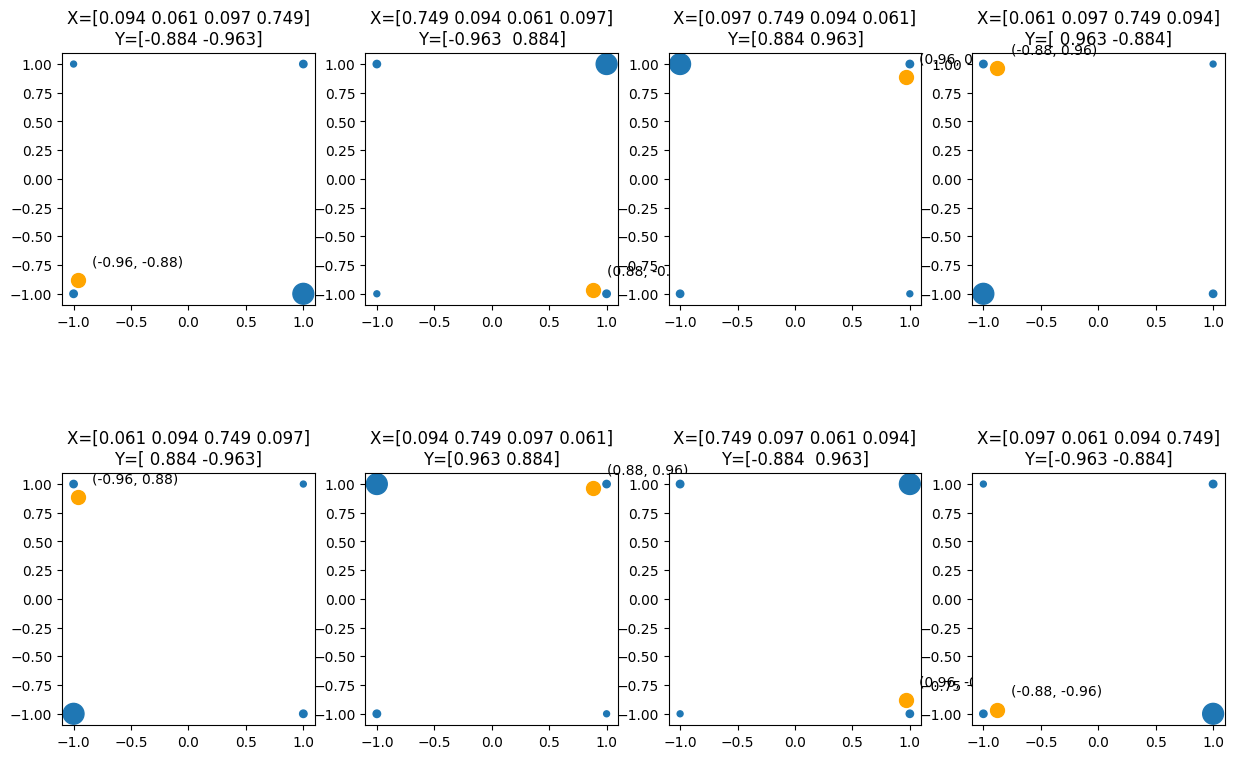

<IPython.core.display.Javascript object>

In [74]:
display_item_all(
    X_train_augmented_h[8:16], y_train_augmented_h[8:16], "augmented_data_h.png"
)

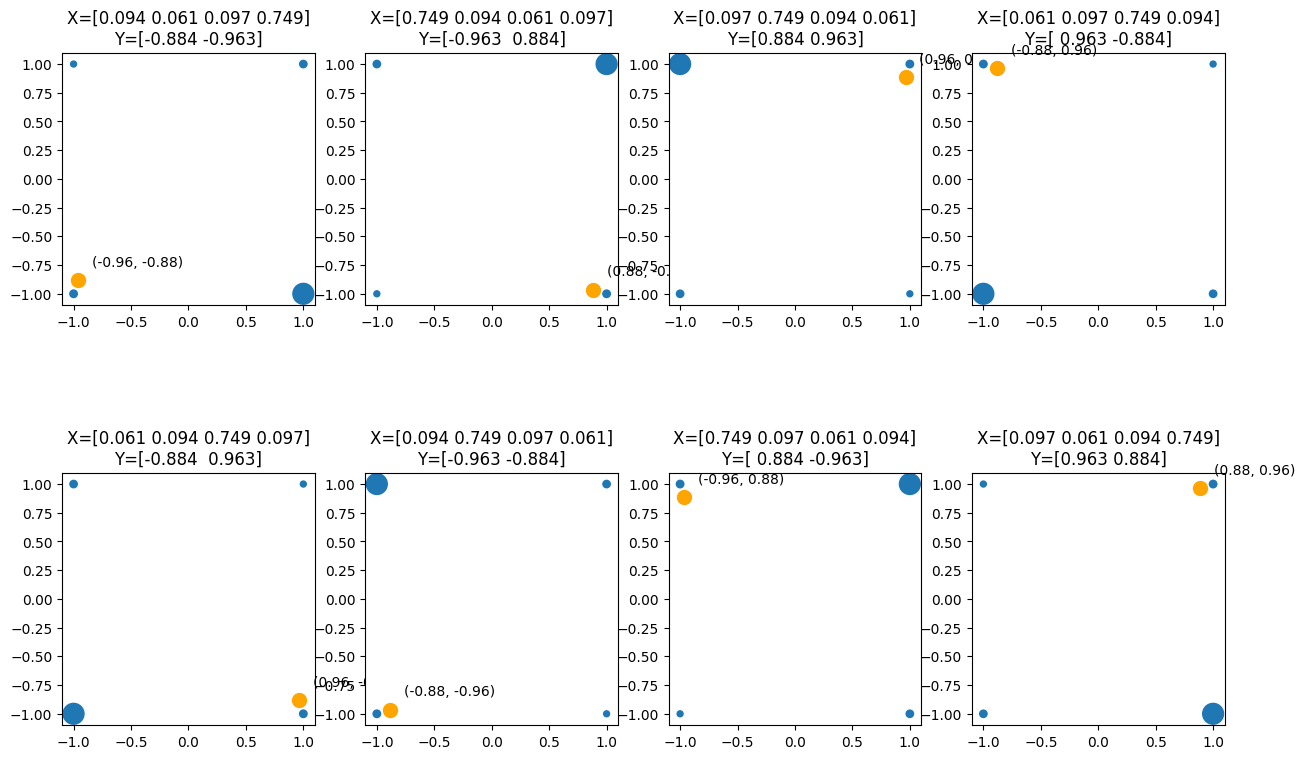

<IPython.core.display.Javascript object>

In [75]:
display_item_all(
    X_train_augmented[8:16], y_train_augmented[8:16], "augmented_data_v.png"
)